In [2]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import joblib
from datetime import datetime, timedelta

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

from utils import get_ticker_prices
from tech_analysis import moving_average, exp_moving_average, \
    vol_moving_average, realized_vol, upper_shadow, lower_shadow

# Loading data #

In [3]:
tickers = ['BTC-USD', 'ETH-USD', '^GSPC', 'AAPL', 'MSFT', 'AMZN', 'GOOG', 'TSLA']
tickers_map = {'BTC-USD': 'BTC', 'ETH-USD': 'ETH', '^GSPC': 'S&P500', 'AAPL': 'AAPL', 
    'MSFT': 'MSFT', 'AMZN': 'AMZN', 'GOOG': 'GOOG', 'TSLA': 'TSLA'}

In [4]:
tickers_data = {}
for ticker in tickers:
    tickers_data[tickers_map[ticker]] = get_ticker_prices(ticker, start='2016-01-01', end=datetime.now()-timedelta(days=1))

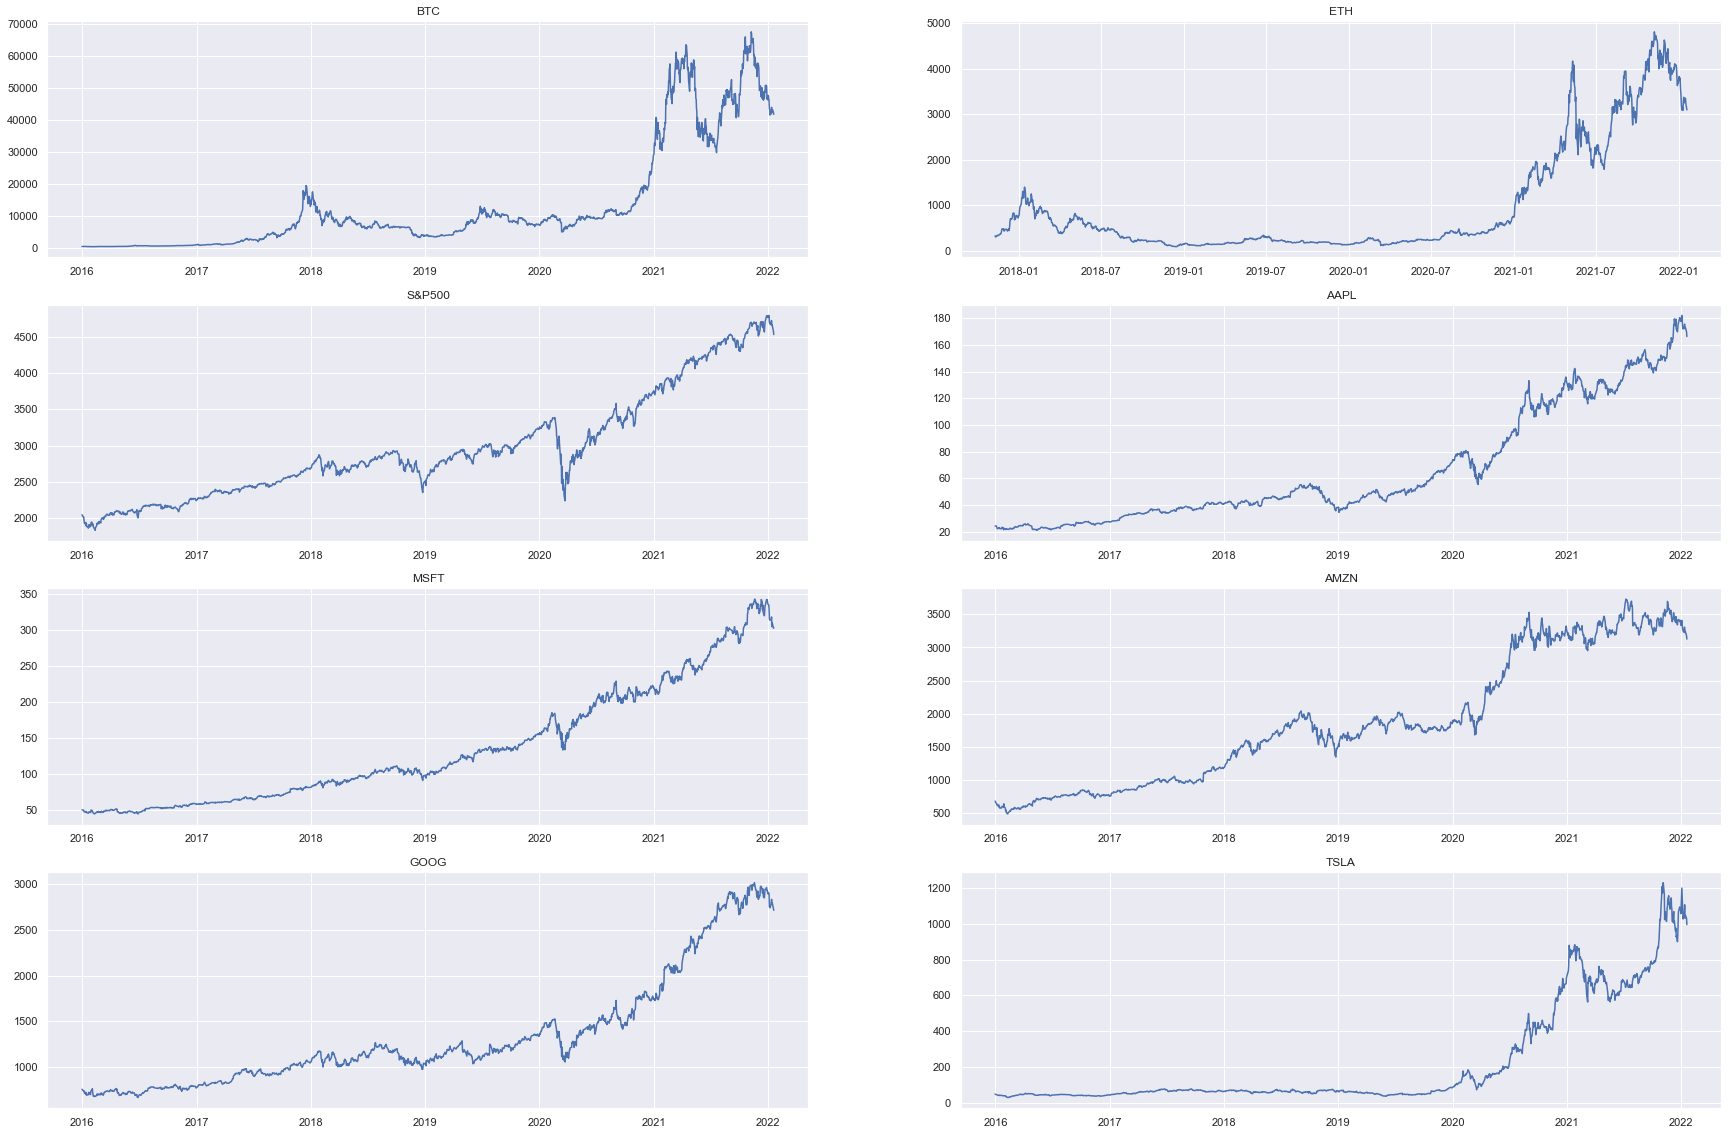

In [5]:
fig = plt.figure(figsize=(30, 20))

for i, ticker in enumerate(tickers):
    ax = fig.add_subplot(420+i+1)
    ax.plot(tickers_data[tickers_map[ticker]].Close)
    ax.set_title(tickers_map[ticker])

In [9]:
def get_feats(df):
    df['MA_3'] = moving_average(df, 3)
    df['MA_9'] = moving_average(df, 9)

    df['EMA_3'] = exp_moving_average(df, 3)
    df['EMA_9'] = exp_moving_average(df, 9)

    df['VMA_3'] = vol_moving_average(df, 3)
    df['VMA_9'] = vol_moving_average(df, 9)

    df['Upper_shadow'] = upper_shadow(df)
    df['Lower_shadow'] = lower_shadow(df)

    df['High_div_low'] = df['High'] / df['Low']
    df['Open_sub_close'] = df['Open'] - df['Close']

    df['Realized_vol'] = realized_vol(df, 21)
    df['Return'] = df['Close'].pct_change()

    return df.dropna()

## Linear Regression ##

In [10]:
for ticker in tickers:
    df = get_feats(tickers_data[tickers_map[ticker]])
    X = df[['MA_3','MA_9', 'Upper_shadow', 'Lower_shadow', 'High_div_low', 'Open_sub_close']]
    y = df['Close']

    if ticker in ('BTC-USD', 'ETH-USD'):
        linreg = LinearRegression()
    else:
        linreg = LinearRegression()
    linreg.fit(X, y)
    joblib.dump(linreg, f'../models/linear/{tickers_map[ticker]}.pk', compress=3)

## XGBoost ##

In [11]:
for ticker in tickers:
    df = get_feats(tickers_data[tickers_map[ticker]])
    X = df.drop(['Return', 'Open_sub_close'], axis=1)
    y = df['Return']

    if ticker in ('BTC-USD', 'ETH-USD'):
        xgb = XGBRegressor(learning_rate=0.2, max_depth=9, min_child_weight=100, n_estimators=100)
    else:
        xgb = XGBRegressor(learning_rate=0.2, max_depth=3, min_child_weight=100, n_estimators=800)
    xgb.fit(X, y)
    joblib.dump(xgb, f'../models/boost/{tickers_map[ticker]}.pk', compress=3)